## Objective:
- explore the relations between our target table and the previous applications
- look into the information we have on previous applications, see how we can use it

## Summary
- An applicant being late and or underpaying on previous applications looks to be a decent feature
- We have some applicants with limited history we;ll need to account for in our feature engineering
	- we see from below and from eda_feature_filtering_selections.sql
- We have a time dimension associated with each previous application we can leverage, and each cc history report
	- We trust newer actions to be more predictive of future ones than we do older actions
	- We can use the columns listed at the bottom to link the application table with the previous application table
- DAYS_TERMINATION can be used to link apps and previous apps
	- but they're for some reason filling some values with the same massive number

In [3]:
import pandas as pd
from plotnine import *
import seaborn as sns
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
DATA_DIR = "./credit_risk/data/original_data"
app = pd.read_csv(DATA_DIR + "/application_train.csv")
prev_app = pd.read_csv(DATA_DIR + "/previous_application.csv")
cc_balance = pd.read_csv(DATA_DIR + "/credit_card_balance.csv")
install_payments = pd.read_csv(DATA_DIR + "/installments_payments.csv")

### App and prev_app

In [5]:
sel_cols = ["AMT_CREDIT", "AMT_ANNUITY", "NAME_CONTRACT_TYPE", "SK_ID_CURR"]
app = app[sel_cols + ["DAYS_EMPLOYED", "AMT_INCOME_TOTAL", "TARGET"]]
prev_app = prev_app[sel_cols + ["SK_ID_PREV"]]

how many previous app per app?

In [6]:
(app.SK_ID_CURR.unique().shape, 
 app.shape, 
 prev_app.shape, 
 prev_app.SK_ID_CURR.unique().shape,
 prev_app.SK_ID_PREV.unique().shape)

((307511,), (307511, 7), (1670214, 5), (338857,), (1670214,))

=> each row in prev_app corresponds to a unique prev application, and ties back to 1 of the current apps

### Prev_app and cc balance

In [7]:
cc_balance.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')

In [8]:
(cc_balance.SK_ID_PREV.unique().shape,
 cc_balance.SK_ID_CURR.unique().shape,
 cc_balance.shape)

((104307,), (103558,), (3840312, 23))

=> balances per previous application, as alluded to in the documentation
=> months are relative the previous applications

Why aren't there much more previous ids than current?
- "the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card"
- could be they were just missing history on these?

In [9]:
cc_balance.MONTHS_BALANCE.head()

0   -6
1   -1
2   -7
3   -4
4   -1
Name: MONTHS_BALANCE, dtype: int64

/Users/bryparker/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/bryparker/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
/Users/bryparker/anaconda3/lib/python3.6/site-packages/plotnine/positions/position.py:188: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  intervals = data[xminmax].drop_duplicates().as_matrix().flatten()


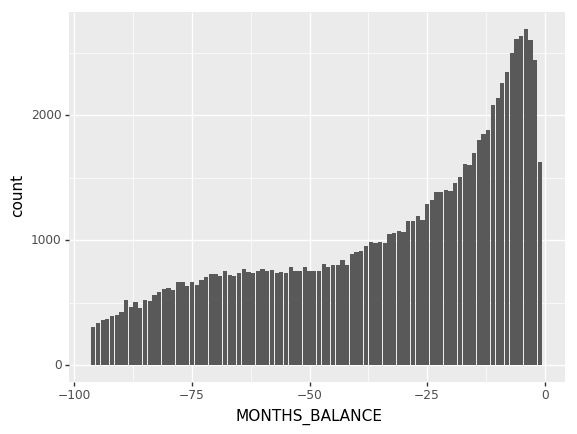

<ggplot: (7587322316)>

In [11]:
cc_bal_sample = cc_balance.sample(n=100000)
ggplot(cc_bal_sample, aes("MONTHS_BALANCE")) +\
    geom_bar()

/Users/bryparker/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/bryparker/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
/Users/bryparker/anaconda3/lib/python3.6/site-packages/plotnine/positions/position.py:188: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  intervals = data[xminmax].drop_duplicates().as_matrix().flatten()


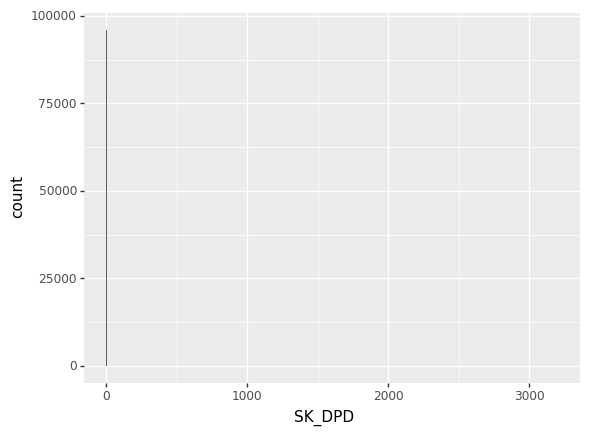

<ggplot: (7568443740)>

In [35]:
ggplot(cc_bal_sample, aes("SK_DPD")) +\
    geom_bar()

/Users/bryparker/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/bryparker/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
/Users/bryparker/anaconda3/lib/python3.6/site-packages/plotnine/positions/position.py:188: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  intervals = data[xminmax].drop_duplicates().as_matrix().flatten()


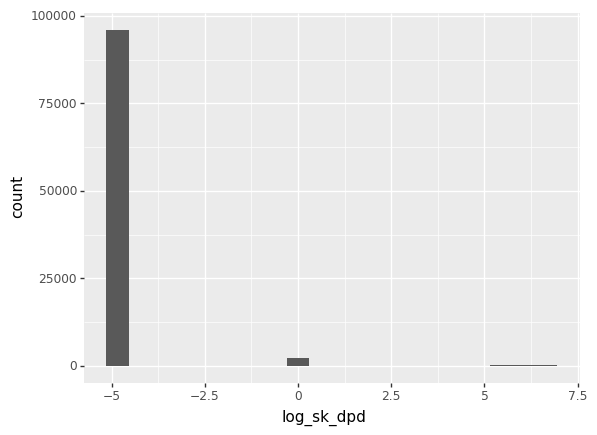

<ggplot: (7550452095)>

In [42]:
import numpy as np
ggplot(cc_bal_sample[cc_bal_sample.SK_DPD < 1000]
       .assign(log_sk_dpd = np.log(cc_bal_sample.SK_DPD + .01)), 
       aes("log_sk_dpd")) +\
    geom_histogram(stat=stat_bin(bins=20))

/Users/bryparker/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/bryparker/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


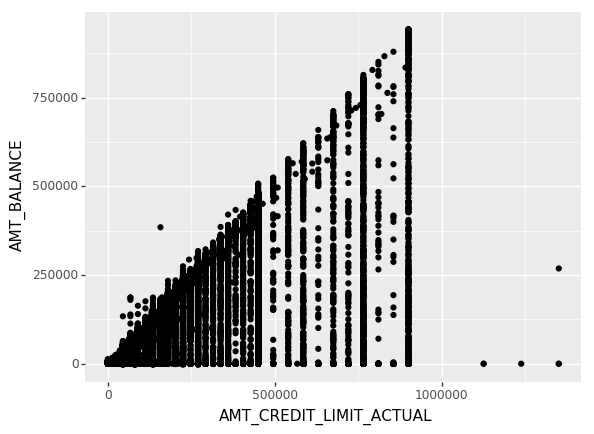

<ggplot: (7570244914)>

In [43]:
ggplot(cc_bal_sample,
       aes("AMT_CREDIT_LIMIT_ACTUAL", "AMT_BALANCE")) +\
    geom_point()

### installments_payments

In [10]:
(install_payments.SK_ID_PREV.unique().shape,
 install_payments.SK_ID_CURR.unique().shape,
 install_payments.shape)


((997752,), (339587,), (13605401, 8))

- => install payments are per previous application
- which it also alludes to in the diagram 

In [12]:
install_payments[["DAYS_ENTRY_PAYMENT", "DAYS_INSTALMENT"]].head()

,DAYS_ENTRY_PAYMENT,DAYS_INSTALMENT
0,-1187.0,-1180.0
1,-2156.0,-2156.0
2,-63.0,-63.0
3,-2426.0,-2418.0
4,-1366.0,-1383.0


In [30]:
payment_per_app_sample = (app.sample(frac=.1)
.merge(install_payments.assign(
    is_late = \
        1*(install_payments.DAYS_ENTRY_PAYMENT > install_payments.DAYS_INSTALMENT),
    underpaid = \
        1*(install_payments.AMT_PAYMENT < install_payments.AMT_INSTALMENT)),
    on="SK_ID_CURR", how="left")
.groupby(["SK_ID_CURR", "TARGET"])
.agg({"is_late": ["mean", "sum", "size"],
      "underpaid": ["mean", "sum", "size"]}))

payment_per_app_sample.head()

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead tr th {
        text-align: left;
    }

    .dataframe thead tr:last-of-type th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr>
      <th></th>
      <th></th>
      <th colspan="3" halign="left">is_late</th>
      <th colspan="3" halign="left">underpaid</th>
    </tr>
    <tr>
      <th></th>
      <th></th>
      <th>mean</th>
      <th>sum</th>
      <th>size</th>
      <th>mean</th>
      <th>sum</th>
      <th>size</th>
    </tr>
    <tr>
      <th>SK_ID_CURR</th>
      <th>TARGET</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>100014</th>
      <th>0</th>
      <td>0.421053</td>
      <td>8.0</td>
      <td>19</td>
      <td>0.526316</td>
      <td>10.0</td>
      <td>19</td>
    </tr>
    <tr>
      <th>100018</th>
      <th>0</th>
      <td>0.000000</td>
      <td>0.0</td>
      <td>24</td>
      <td>0.000000</td>
      <td>0.0</td>
      <td>24</td>
    </tr>
    <tr>
      <th>100021</th>
      <th>0</th>
      <td>0.173913</td>
      <td>4.0</td>
      <td>23</td>
      <td>0.000000</td>
      <td>0.0</td>
      <td>23</td>
    </tr>
    <tr>
      <th>100048</th>
      <th>0</th>
      <td>0.014925</td>
      <td>1.0</td>
      <td>67</td>
      <td>0.000000</td>
      <td>0.0</td>
      <td>67</td>
    </tr>
    <tr>
      <th>100049</th>
      <th>1</th>
      <td>0.068966</td>
      <td>4.0</td>
      <td>58</td>
      <td>0.103448</td>
      <td>6.0</td>
      <td>58</td>
    </tr>
  </tbody>
</table>
</div>

/Users/bryparker/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/bryparker/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
/Users/bryparker/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:450: UserWarning: geom_point : Removed 1602 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


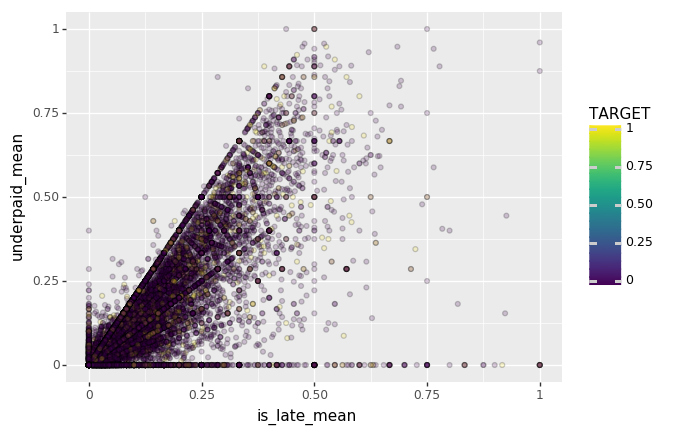

In [31]:

def convert_from_multindex(df1):
    df = pd.DataFrame([])
    cols = df1.columns
    for c in cols:
        nc = [sub_col for sub_col in c if len(sub_col) > 0]
        new_col = '_'.join(nc)
        df[new_col] = df1[c]
    return df

payment_per_app_sample_cleaned = (convert_from_multindex(payment_per_app_sample)
                                  .reset_index())

(ggplot(payment_per_app_sample_cleaned, 
       aes("is_late_mean", "underpaid_mean", fill="TARGET")) +
        geom_point(alpha=.2))

to understand why this is happening, and learn an effective way to model it: http://varianceexplained.org/r/empirical_bayes_baseball/

/Users/bryparker/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/bryparker/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
/Users/bryparker/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:450: UserWarning: geom_point : Removed 1602 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


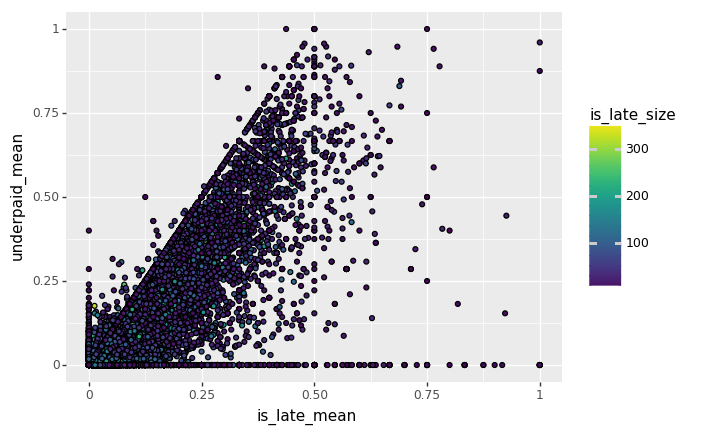

<ggplot: (7579433676)>

In [79]:
(ggplot(payment_per_app_sample_cleaned, 
       aes("is_late_mean", "underpaid_mean", fill="is_late_size")) +
     geom_point()
 )

/Users/bryparker/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/bryparker/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


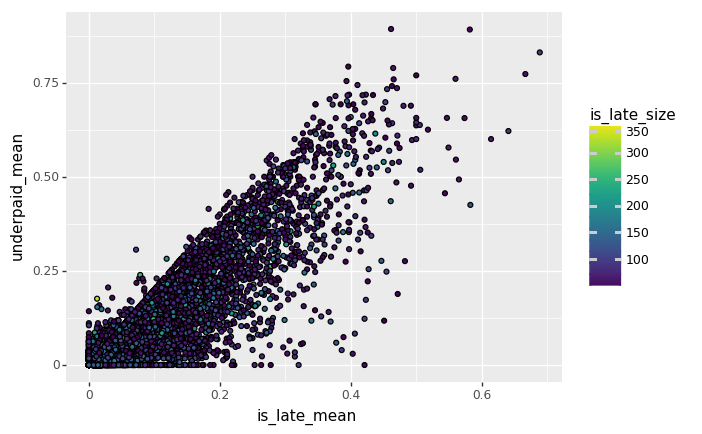

<ggplot: (-9223372029284799719)>

In [81]:
(ggplot(payment_per_app_sample_cleaned[
    payment_per_app_sample_cleaned.is_late_size > 50
        ], 
       aes("is_late_mean", "underpaid_mean", fill="is_late_size")) +
     geom_point()
 )

/Users/bryparker/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/bryparker/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


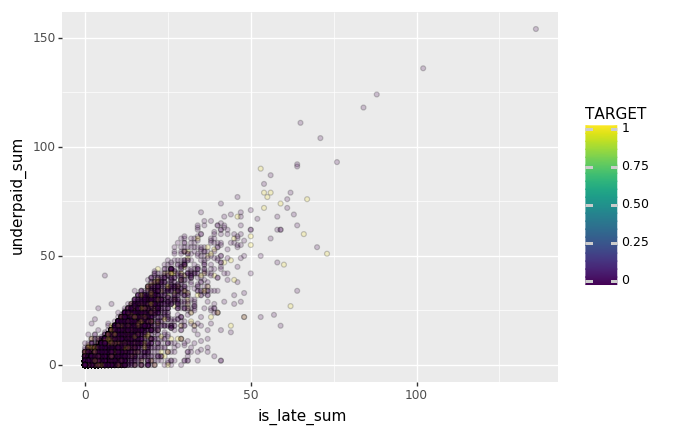

<ggplot: (-9223372029315949326)>

In [27]:
(ggplot(payment_per_app_sample_cleaned, 
       aes("is_late_sum", "underpaid_sum", fill="TARGET")) +
        geom_point(alpha=.2))

/Users/bryparker/anaconda3/lib/python3.6/site-packages/plotnine/utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
/Users/bryparker/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/bryparker/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


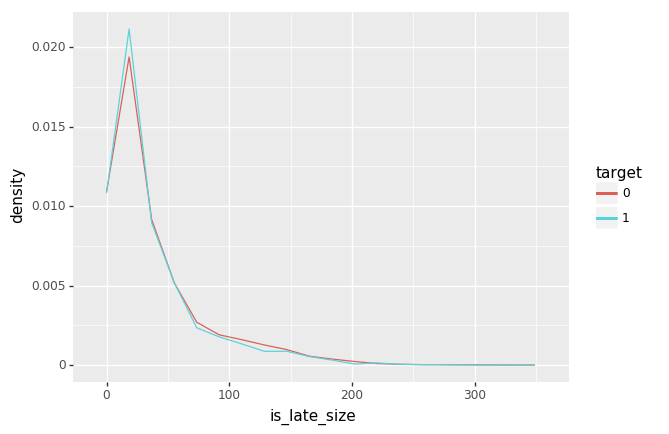

<ggplot: (7538925702)>

In [34]:
ggplot(payment_per_app_sample_cleaned
       .assign(target=payment_per_app_sample_cleaned.TARGET.astype(str)), 
       aes("is_late_size", y="..density..", color="target")) +\
       geom_freqpoly(stat=stat_bin(bins=20))

=> we need to be careful when deriving these features, bc we don't trust the mean over these small count features
- just like you don't a 5 star review with 5 ratings on it

In [57]:
counts_per__prev_id = (cc_balance
    .groupby("SK_ID_PREV")
    .agg({"SK_ID_PREV": "size"})
)

print(counts_per__prev_id.shape)
counts_per__prev_id.head()

(104307, 1)


,SK_ID_PREV
SK_ID_PREV,
1000018,5
1000030,8
1000031,16
1000035,5
1000077,11


/Users/bryparker/anaconda3/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:90: UserWarning: 'stat_bin()' using 'bins = 16'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))
/Users/bryparker/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/bryparker/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
/Users/bryparker/anaconda3/lib/python3.6/site-packages/plotnine/positions/position.py:188: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  intervals = data[xminmax].drop_duplicates().as_matrix().flatten()


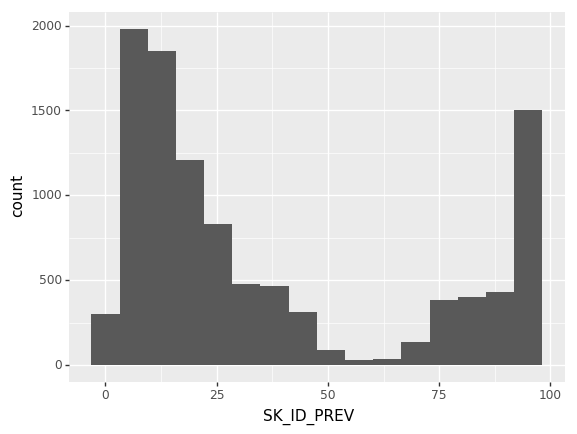

<ggplot: (-9223372029304747488)>

In [58]:
ggplot(
    counts_per__prev_id.sample(frac=.1),
    aes("SK_ID_PREV")
) +\
    geom_histogram()

- assuming from 2 different types of mortgages lengths people usually get
- notice its also interesting that we have previous applications with such short lifespans
	- of course some will be from the previous application still having payments right now
	- we don't have a feature for previously defaulting on a loan
	- but could probably make one w this
	- use the days_termination feature below as well as the number of months recorded in cc balance for a given previous application
		- but note this is also susceptible to missing data
		- we would have to look into if considering this feature

### What should we be filtering by in the install payments?

In [66]:
install_payments_grouped = (install_payments
                            .groupby("SK_ID_PREV")
                            .count()
                            .iloc[:,:1])
install_payments_grouped.head()

,SK_ID_CURR
SK_ID_PREV,
1000001,2
1000002,4
1000003,3
1000004,7
1000005,11


In [74]:
(pd.DataFrame(install_payments_grouped)
    .reset_index()
    .rename(
    columns={"SK_ID_CURR":"counts"}
).head())

,SK_ID_PREV,counts
0,1000001,2
1,1000002,4
2,1000003,3
3,1000004,7
4,1000005,11


/Users/bryparker/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/bryparker/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
/Users/bryparker/anaconda3/lib/python3.6/site-packages/plotnine/positions/position.py:188: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  intervals = data[xminmax].drop_duplicates().as_matrix().flatten()


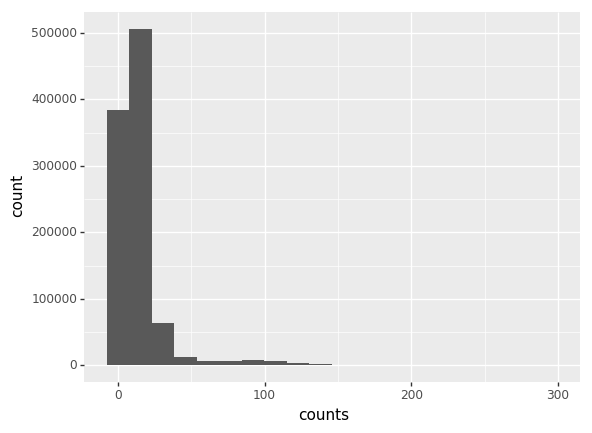

<ggplot: (7576799787)>

In [76]:
ggplot(install_payments_grouped.reset_index()
       .rename(
    columns={"SK_ID_CURR": "counts"}),
       aes("counts")) + \
geom_histogram(stat=stat_bin(bins=20))


### how can we relate the time of the current application to cc balance and payment history?

how can we relate the time between current application and previous applications?

- DAYS_FIRST_DUE: Relative to application date of current application when was the first due supposed to be of the previous application
- DAYS_LAST_DUE_1ST_VERSION: Relative to application date of current application when was the first due of the previous application
- DAYS_LAST_DUE: Relative to application date of current application when was the last due date of the previous application
- DAYS_TERMINATION: Relative to application date of current application when was the expected termination of the previous application

/Users/bryparker/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:363: UserWarning: stat_bin : Removed 269027 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/Users/bryparker/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/bryparker/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
/Users/bryparker/anaconda3/lib/python3.6/site-packages/plotnine/positions/position.py:188: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  intervals = data[xminmax].drop_duplicates().as_matrix().flatten()


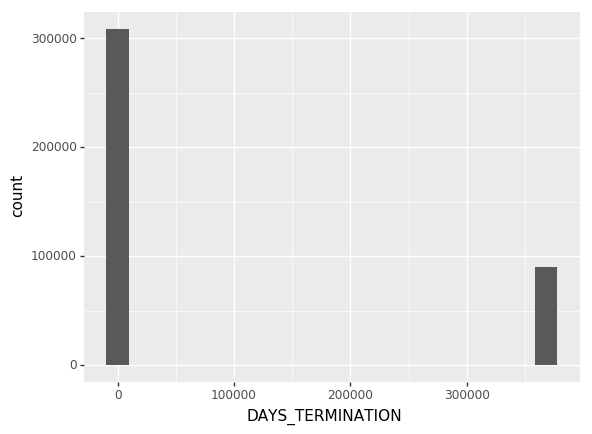

<ggplot: (-9223372029304040711)>

In [83]:
prev_app = pd.read_csv(DATA_DIR + "/previous_application.csv")
ggplot(prev_app.sample(frac=.4),
       aes("DAYS_TERMINATION")) +\
    geom_histogram(stat=stat_bin(bins=20))

weird...

"Relative to application date of current application when was the expected termination of the previous application"

/Users/bryparker/anaconda3/lib/python3.6/site-packages/plotnine/utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
/Users/bryparker/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:363: UserWarning: stat_bin : Removed 67296 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/Users/bryparker/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/bryparker/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
/Users/bryparker/anaconda3/lib/python3.6/site-packages/plotnine/positions/position.py:188: FutureWarning: Method .as_matrix will be remo

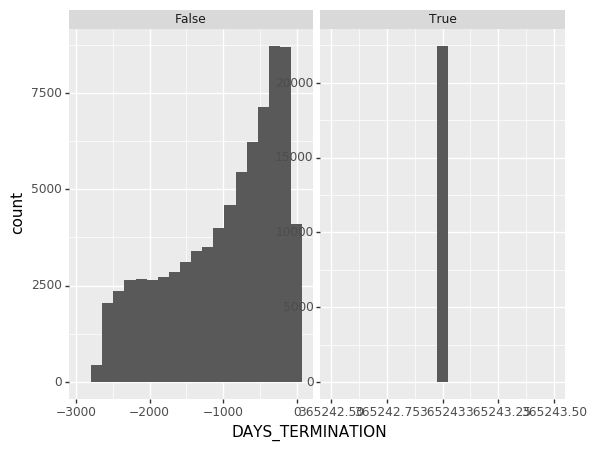

<ggplot: (7538548530)>

In [85]:
prev_app_sample = (prev_app.sample(frac=.1))
prev_app_sample = (prev_app_sample
                   .assign(days_term_gt_100g 
                      = prev_app_sample.DAYS_TERMINATION > 100000))

ggplot(prev_app_sample,
       aes("DAYS_TERMINATION")) +\
    geom_histogram(stat=stat_bin(bins=20)) +\
    facet_wrap("~ days_term_gt_100g", scales="free")

same weird thing we were seeing with DAYS_EMPLOYED it looks like
- need to take this into account when modelling / feature engineering